In [1]:
import pickle
import numpy as np
import pandas as pd

DATA = {
    "X" : [],
    "category" : [],
    "y" : []
}

X=DATA["X"]
category=DATA["category"]
y=DATA["y"]


with open('covid_fake_news_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(0,len(dst)))
    data = pd.read_csv("raw/covid_fake_news.csv",sep="\t")
    y.extend(data["label"].values)
    
with open('mmcovid_en_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(1,len(dst)))
    data = pd.read_csv("raw/mmcovid_en.csv",sep=",")
    y.extend(data["label"].values)
    

with open('pubhealth_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(2,len(dst)))
    data = pd.read_csv("raw/pubhealth.csv",sep=",")
    y.extend(data["label"].values)

    
with open('qprop_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(3,len(dst)))
    data = pd.read_csv("raw/qprop.csv",sep="\t")
    y.extend(data["label"].values)
    
with open('isot_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(4,len(dst)))
    data = pd.read_csv("raw/isot.csv",sep=",")
    y.extend(data["label"].values)
    
with open('grafn_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(5,len(dst)))
    data = pd.read_csv("raw/grafn.csv",sep=",")
    y.extend(data["label"].values)
    
    
DATA["X"]=np.array(X)
DATA["category"]=np.array(category)
DATA["y"]=np.array(y)
DATA["folds"] = []

/tmp/ipykernel_3961/3486400938.py:57: DtypeWarning: Columns (3,5,6,9,10,11,12,13,14,16,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("raw/grafn.csv",sep=",")


In [3]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def experiment(foldids, X, y, cls = LogisticRegression(max_iter=10000), fit=True):

    scores = {
        'Accuracy': {'func': accuracy_score},
        'Balanced Accuracy': {'func': balanced_accuracy_score},
        'F1': {'func': f1_score},
        'Precision': {'func': precision_score},
        'Recall': {'func': recall_score},
        'G-mean': {'func': geometric_mean_score}
    }

    for score_name, score_dict in scores.items():
        scores[score_name]["list"] = []
        scores[score_name]["lab"] = []

    for fold,j in enumerate(foldids):
        train = foldids[fold][1]
        test = foldids[fold][2]
        xin, yin = X[train], np.array(y[train])
        
        pca = PCA(n_components=512)
        pca.fit(xin)
        
        
        if fit == True:
            cls.fit(pca.transform(xin), yin)
        y_pred = cls.predict(pca.transform(X[test]))
        for score_name, score_dict in scores.items():
            if score_name in ["F1","Precision","Recall"]:
                scorvaln = score_dict['func'](y[test], y_pred, average=None)
                score_dict['lab'].append(scorvaln)
                scorval = score_dict['func'](y[test], y_pred, average="weighted")
                score_dict['list'].append(scorval)
                #print(score_name, scorval, scorvaln)  
            else:
                scorval=score_dict['func'](y[test], y_pred)
                score_dict['list'].append(scorval)
                #print(score_name, scorval)
        #print(" ")

    #clear_output()
    for score_name, score_dict in scores.items():
        score_dict['avg'] = np.mean(score_dict['list'])
        score_dict['std'] = np.std(score_dict['list'])
 
    # Print stats
    numlabels = scores["F1"]["lab"][0].shape[0]
    scores["F1"]["lab"][0].shape[0] 
    head = "| %-20s | %-10s |" +  numlabels * " %-10s |" 
    headv = ["Score", "Average"]
    headv.extend(["Kat_"+str(i+1) for i in range(numlabels)])
    row=head % tuple(headv)
    print("+"*len(row))
    print(row)
    print("+"*len(row))
    for score_name, score_dict in sorted(scores.items()) :
        headv = [score_name, np.mean(score_dict['list'])*100, np.std(score_dict['list'])*100]
        for i in range(numlabels):
            if score_name in ["F1","Precision","Recall"]:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels* " %4.1f ± %3.1f |"
                vals = [v[i] for v in scores[score_name]["lab"]]
                headv.append(np.mean(vals)*100)
                headv.append(np.std(vals)*100)
            else:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels * " %-10s |" 
                headv.append("-")
        print(head % tuple(headv))
    print("+"*len(row))
    return cls, scores, pca

<hr style="border: 5px dashed red">

# Single Task Performance

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.decomposition import PCA

DATA["folds"] = []
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

stl=[]

for t in range(np.max(DATA["category"]+1)):
    print("TASK",t)
    X = DATA["X"][DATA["category"] == t]
    y = DATA["y"][DATA["category"] == t]

    foldids = []
    for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
        foldids.append((fold_idx,train,test))

    #print("shapes X",X.shape,"y", y.shape)
    DATA["folds"].append(foldids)
    model1, scores1, pca = experiment(foldids, X, y, 
                                 LogisticRegression(max_iter=10000))
    stl.append((model1,pca,scores1))

TASK 0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 97.2 ± 0.1 | -          | -          |
| Balanced Accuracy    | 79.2 ± 1.3 | -          | -          |
| F1                   | 97.0 ± 0.1 | 68.6 ± 1.6 | 98.5 ± 0.1 |
| G-mean               | 76.7 ± 1.8 | -          | -          |
| Precision            | 97.0 ± 0.1 | 81.7 ± 3.4 | 97.8 ± 0.1 |
| Recall               | 97.2 ± 0.1 | 59.2 ± 2.8 | 99.3 ± 0.2 |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TASK 1
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 92.6 ± 0.2 | -          | -          |
| Balanced Accuracy    | 88.2 ± 0.7 | -          | -          |
| F1                   | 9

In [4]:
T = np.max(DATA["category"])+1
d = 128

stl_bacs = [[] for b in range(T)]

ft = 0

for ft in range(6):
    print("STL-",ft)
    for _foldid in range(10):
        #print("fold",_foldid)

        ##### Test
        for task in range(T):
            X = DATA["X"][DATA["category"] == task]
            y = DATA["y"][DATA["category"] == task]
            foldids = DATA["folds"][task]

            train = foldids[_foldid][1]
            test = foldids[_foldid][2]    

            X=stl[ft][1].transform(X[test])

            #print(np.unique(domain_pred, return_counts=True))
            #print("task",task, pred_task_id)

            pred=stl[ft][0].predict(X)
            bac = balanced_accuracy_score(y[test], pred)
            #print(task,bac)
            stl_bacs[task].append(bac)
            


STL- 0
STL- 1
STL- 2
STL- 3
STL- 4
STL- 5


In [5]:
stl_corrmat = [[] for b in range(T)]
for c in range(6):
    print(f"STL-{c}")
    for rr in range(T):
        mm = np.mean(stl_bacs[c][rr*10:(rr*10+10)])
        stl_corrmat[c].append(mm)
        print(f"  task_{rr}",mm)

STL-0
  task_0 0.7922017510225464
  task_1 0.5680621718407759
  task_2 0.45648946662605133
  task_3 0.5013823235848408
  task_4 0.6359406093216162
  task_5 0.5881855769277108
STL-1
  task_0 0.5739572456201416
  task_1 0.8851374869474418
  task_2 0.46195904397261867
  task_3 0.520115442626755
  task_4 0.5002683025873071
  task_5 0.6093369300382876
STL-2
  task_0 0.48466993446737316
  task_1 0.4415143779876723
  task_2 0.7957449298951854
  task_3 0.39531630789749145
  task_4 0.3600732780851347
  task_5 0.3855804823530864
STL-3
  task_0 0.5059110388430146
  task_1 0.5058960378680661
  task_2 0.2640901309114179
  task_3 0.7705084002703024
  task_4 0.6656702963972114
  task_5 0.7185656407745704
STL-4
  task_0 0.5074418111296175
  task_1 0.5238818371239836
  task_2 0.20666938030794885
  task_3 0.6648356666928218
  task_4 0.9927483479179923
  task_5 0.6508583861740117
STL-5
  task_0 0.5376226061682939
  task_1 0.4916815438827534
  task_2 0.3383951907738127
  task_3 0.644569263413119
  task_4 

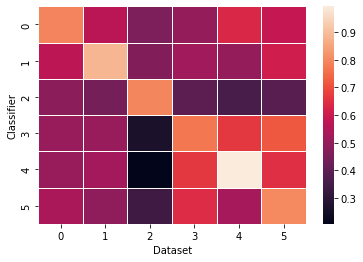

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.array(stl_corrmat)
ax = sns.heatmap(uniform_data, linewidth=0.5)
ax.set(xlabel='Dataset', ylabel='Classifier')
plt.show()

# Batch Multi Task Performance

In [4]:
X = DATA["X"]
y = DATA["y"]

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

model3, scores3, model3_pca = experiment(foldids, X, y, 
                             LogisticRegression(max_iter=10000))

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 169.94it/s]

shapes X (186477, 768) y (186477,)


+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 84.5 ± 0.1 | -          | -          |
| Balanced Accuracy    | 77.7 ± 0.1 | -          | -          |
| F1                   | 84.0 ± 0.1 | 89.7 ± 0.1 | 68.9 ± 0.2 |
| G-mean               | 76.3 ± 0.2 | -          | -          |
| Precision            | 84.0 ± 0.1 | 86.9 ± 0.1 | 76.3 ± 0.3 |
| Recall               | 84.5 ± 0.1 | 92.7 ± 0.1 | 62.8 ± 0.3 |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [5]:
T = np.max(DATA["category"])+1
d = 128

_bacs = [[] for b in range(T)]


for _foldid in range(10):
    print("fold",_foldid)

    ##### Test
    for task in range(T):
        X = DATA["X"][DATA["category"] == task]
        y = DATA["y"][DATA["category"] == task]
        foldids = DATA["folds"][task]
        
        train = foldids[_foldid][1]
        test = foldids[_foldid][2]    
        
        X=model3_pca.transform(X[test])

        #print(np.unique(domain_pred, return_counts=True))
        #print("task",task, pred_task_id)

        pred=model3.predict(X)
        bac = balanced_accuracy_score(y[test], pred)
        print(task,bac)
        _bacs[task].append(bac)



fold 0
0 0.49759623242889833
1 0.6827648219050935
2 0.42324744822202087
3 0.7740426345626505
4 0.8954930213517331
5 0.7415292180821338
fold 1
0 0.5046861090339351
1 0.6956143404107205
2 0.40334829229467034
3 0.7721165139737413
4 0.8929018452055881
5 0.7409854492895602
fold 2
0 0.507643429225237
1 0.6899727346559925
2 0.4081338054532713
3 0.7723664995930211
4 0.893690589254943
5 0.7411778912232476
fold 3
0 0.4946861599035512
1 0.6884064276598213
2 0.4184691154516677
3 0.7737926489433709
4 0.8947044891947944
5 0.7413364206470661
fold 4
0 0.495481570774763
1 0.6918581041884209
2 0.41274118119158965
3 0.7720576816661714
4 0.8970492567177326
5 0.741581899741727
fold 5
0 0.5068012676708329
1 0.6865210581273931
2 0.41386047258601155
3 0.7741014668702204
4 0.8913456106829852
5 0.7409325319905253
fold 6
0 0.499711915658712
1 0.682822833275322
2 0.41168017323402994
3 0.7746342426910564
4 0.8953652639205092
5 0.7428369103898261
fold 7
0 0.5025897721549896
1 0.6955563290404919
2 0.4149220437112769

In [19]:
for t in range(T):
    print("%3.1f ± %3.2f &" % (np.mean(_bacs[t])*100, 100*np.std(_bacs[t])) )

print("---")
print(np.mean(np.array(_bacs).flatten())*100, np.std(np.array(_bacs).flatten())*100)

50.1 ± 0.43 &
68.9 ± 0.42 &
41.3 ± 0.52 &
77.3 ± 0.21 &
89.4 ± 0.15 &
74.1 ± 0.11 &
---
66.86956697284273 16.370773622340355


<hr style="border: 5px dashed red">

# Domain Classifier

In [7]:
X = DATA["X"]
y = DATA["y"]
category = DATA["category"]

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", category.shape)

domain_model, domain_scores, domain_pca = experiment(foldids, X, 
                                         category, LogisticRegression(max_iter=10000, class_weight='balanced'))

shapes X (186477, 768) y (186477,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      | Kat_3      | Kat_4      | Kat_5      | Kat_6      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 71.4 ± 0.1 | -          | -          | -          | -          | -          | -          |
| Balanced Accuracy    | 80.0 ± 0.1 | -          | -          | -          | -          | -          | -          |
| F1                   | 71.3 ± 0.1 | 94.8 ± 0.2 | 77.2 ± 0.5 | 64.0 ± 0.3 | 64.0 ± 0.2 | 76.7 ± 0.3 | 70.4 ± 0.1 |
| G-mean               | 78.9 ± 0.1 | -          | -          | -          | -          | -          | -          |
| Precision            | 72.4 ± 0.1 | 92.3 ± 0.4 | 67.6 ± 0.8 | 51.1 ± 0.5 | 65.8 ± 0.2 | 72.9 ± 0.3 | 78.6 ± 0.2 |
| Recall               | 71.4 ± 0.1 |

<hr style="border: 5px dashed red">

In [23]:
T = np.max(DATA["category"])+1
d = 128

_bacs = [[] for b in range(T)]


for _foldid in range(10):
    print("fold",_foldid)

    ##### Test
    for task in range(T):

        X = DATA["X"][DATA["category"] == task]
        y = DATA["y"][DATA["category"] == task]
        foldids = DATA["folds"][task]

        train = foldids[_foldid][1]
        test = foldids[_foldid][2]   

        X_test=X[test]
        X=domain_pca.transform(X_test)
        domain_pred = domain_model.predict(X)
        ypred = []
        for i,dpred in enumerate(domain_pred):
            model, model_pca, _ = stl[dpred] 
            xpca = model_pca.transform(X_test[i:i+1])
            ypred.append(model.predict(xpca))
    
        bac = balanced_accuracy_score(y[test], ypred)
        print(task,bac)
        _bacs[task].append(bac)


fold 0
0 0.785959463877084
1 0.8355087597169045
2 0.7318468958450586
3 0.7340478299998547
4 0.9056805549753542
5 0.7377939857119122
fold 1
0 0.7836978141325968
1 0.838945933402947
2 0.7477834273697479
3 0.7305730023249903
4 0.9059094724095687
5 0.7360276216216628
fold 2
0 0.7883683393265773
1 0.8516359206404456
2 0.729211537830587
3 0.7316260799553342
4 0.905326040432435
5 0.738857980032926
fold 3
0 0.7812982943417726
1 0.8228187724794059
2 0.7504176590488081
3 0.7329947523695108
4 0.9062640755129145
5 0.7349633422329218
fold 4
0 0.7813174239947696
1 0.840077155122404
2 0.7507750186971947
3 0.7301806797366739
4 0.9070967081598071
5 0.7378579800329261
fold 5
0 0.7883111796155274
1 0.8343775379974475
2 0.7288468570020261
3 0.7344401525881713
4 0.9044933069877221
5 0.7359634961027479
fold 6
0 0.8008826413860739
1 0.838742893607147
2 0.7363966446843182
3 0.7347202320469343
4 0.9049961753901612
5 0.7394685163648447
fold 7
0 0.7688306601350079
1 0.8357117995127045
2 0.7432331153627826
3 0.72

In [24]:
for t in range(T):
    print("%3.1f ± %3.2f &" % (np.mean(_bacs[t])*100, 100*np.std(_bacs[t])) )

print("---")
print(np.mean(np.array(_bacs).flatten())*100, np.std(np.array(_bacs).flatten())*100)

78.5 ± 1.02 &
83.7 ± 0.71 &
74.0 ± 0.85 &
73.2 ± 0.21 &
90.6 ± 0.08 &
73.7 ± 0.16 &
---
78.9482486171734 6.398567794675282


In [21]:
task = 0 

X = DATA["X"][DATA["category"] == task]
y = DATA["y"][DATA["category"] == task]
foldids = DATA["folds"][task]

train = foldids[_foldid][1]
test = foldids[_foldid][2]   

X_test=X[test]
X=domain_pca.transform(X_test)
domain_pred = domain_model.predict(X)
ypred = []
for i,dpred in enumerate(domain_pred):
    model, model_pca, _ = stl[dpred] 
    xpca = model_pca.transform(X_test[i:i+1])
    ypred.append(model.predict(xpca))

In [22]:
balanced_accuracy_score(y[test], ypred)

0.7694182042008129

In [13]:
np.unique(domain_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([4374,   82,    7,    7,    7,    9]))

In [82]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def cls_max_predict(X_test):
    ypred = np.array([stl[t][0].predict(stl[t][1].transform(X_test)) for t in range(6)])
    return np.mean(ypred, axis=0) > 0.5

def cls_weighted_predict(X_test):
    ypred = np.array([stl[t][0].predict(stl[t][1].transform(X_test)) for t in range(6)])
    return np.average(ypred, weights=[78,83,74,73,90,73], axis=0) > 0.4

def cls_max_predict_raw(X_test):
    ypred = np.array([stl[t][0].predict(stl[t][1].transform(X_test)) for t in range(6)])
    return ypred

def cls_predict(X_test):
    Xd=domain_pca.transform(X_test)
    domain_pred = domain_model.predict(Xd)
    ypred = []
    for i,dpred in enumerate(domain_pred):
        model, model_pca, _ = stl[dpred] 
        xpca = model_pca.transform(X_test[i:i+1])
        ypred.append(model.predict(xpca)[0])
    return ypred
        
def experiment2(foldids, X, y, cback):

    scores = {
        'Accuracy': {'func': accuracy_score},
        'Balanced Accuracy': {'func': balanced_accuracy_score},
        'F1': {'func': f1_score},
        'Precision': {'func': precision_score},
        'Recall': {'func': recall_score},
        'G-mean': {'func': geometric_mean_score}
    }

    for score_name, score_dict in scores.items():
        scores[score_name]["list"] = []
        scores[score_name]["lab"] = []

    for fold,j in enumerate(foldids):
        train = foldids[fold][1]
        test = foldids[fold][2]
        xin, yin = X[train], np.array(y[train])
        
        y_pred = cback(X[test])
        
        for score_name, score_dict in scores.items():
            if score_name in ["F1","Precision","Recall"]:
                scorvaln = score_dict['func'](y[test], y_pred, average=None)
                score_dict['lab'].append(scorvaln)
                scorval = score_dict['func'](y[test], y_pred, average="weighted")
                score_dict['list'].append(scorval)
                print(score_name, scorval, scorvaln)  
            else:
                scorval=score_dict['func'](y[test], y_pred)
                score_dict['list'].append(scorval)
                print(score_name, scorval)
        print(" ")

    #clear_output()
    for score_name, score_dict in scores.items():
        score_dict['avg'] = np.mean(score_dict['list'])
        score_dict['std'] = np.std(score_dict['list'])
 
    # Print stats
    numlabels = scores["F1"]["lab"][0].shape[0]
    scores["F1"]["lab"][0].shape[0] 
    head = "| %-20s | %-10s |" +  numlabels * " %-10s |" 
    headv = ["Score", "Average"]
    headv.extend(["Kat_"+str(i+1) for i in range(numlabels)])
    row=head % tuple(headv)
    print("+"*len(row))
    print(row)
    print("+"*len(row))
    for score_name, score_dict in sorted(scores.items()) :
        headv = [score_name, np.mean(score_dict['list'])*100, np.std(score_dict['list'])*100]
        for i in range(numlabels):
            if score_name in ["F1","Precision","Recall"]:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels* " %4.1f ± %3.1f |"
                vals = [v[i] for v in scores[score_name]["lab"]]
                headv.append(np.mean(vals)*100)
                headv.append(np.std(vals)*100)
            else:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels * " %-10s |" 
                headv.append("-")
        print(head % tuple(headv))
    print("+"*len(row))
    return scores, pca

In [31]:
X = DATA["X"]
y = DATA["y"]


rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

experiment2(foldids, X, y)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 173.47it/s]


shapes X (186477, 768) y (186477,)
Accuracy 0.8466628771222342
Balanced Accuracy 0.8265638859215866
F1 0.8472128734983001 [0.8870704  0.76122718]
Precision 0.8479024603650341 [0.89281796 0.75100507]
Recall 0.8466628771222342 [0.88139637 0.7717314 ]
G-mean 0.8247431455284931
 
Accuracy 0.8480662390870675
Balanced Accuracy 0.8281604176488347
F1 0.8486079978416302 [0.88810957 0.76338734]
Precision 0.8492879631964874 [0.8938281 0.7531971]
Recall 0.8480662390870675 [0.88246374 0.77385709]
G-mean 0.8263781376906907
 
Accuracy 0.8484003474940743
Balanced Accuracy 0.8287708661953155
F1 0.8489724911273285 [0.8883112  0.76410607]
Precision 0.8497000527855766 [0.89438177 0.75330701]
Recall 0.8484003474940743 [0.88232247 0.77521926]
G-mean 0.827038919427316
 
Accuracy 0.8463287500804393
Balanced Accuracy 0.8259533783188882
F1 0.8468478233984006 [0.88686932 0.76050547]
Precision 0.8474902187052603 [0.8922659  0.75089121]
Recall 0.8463287500804393 [0.88153764 0.77036912]
G-mean 0.8240809262177261
 


NameError: name 'cls' is not defined

In [60]:
X = DATA["X"]
y = DATA["y"]


rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

experiment2(foldids, X, y, cls_max_predict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 171.36it/s]


shapes X (186477, 768) y (186477,)
Accuracy 0.6633275775158464
Balanced Accuracy 0.6579710590973742
F1 0.6735337611642233 [0.73190479 0.54760841]
Precision 0.6994385916303019 [0.80270134 0.47666717]
Recall 0.6633275775158464 [0.67258429 0.64335783]
G-mean 0.6578087625352369
 
Accuracy 0.6630451103627276
Balanced Accuracy 0.656661845737891
F1 0.6731503648039077 [0.7321768  0.54580677]
Precision 0.698293392630676 [0.80123888 0.47619888]
Recall 0.6630451103627276 [0.67407547 0.63924822]
G-mean 0.6564309143857618
 
Accuracy 0.6634884544021279
Balanced Accuracy 0.6584793549674552
F1 0.6737250587820719 [0.73187031 0.54828678]
Precision 0.6998828125455716 [0.80324517 0.47689649]
Recall 0.6634884544021279 [0.67214479 0.64481392]
G-mean 0.6583375402667039
 
Accuracy 0.6628842317510029
Balanced Accuracy 0.6561535252132725
F1 0.6729571824826037 [0.73221101 0.54512301]
Precision 0.697852045106714 [0.8007006  0.47596664]
Recall 0.6628842317510029 [0.67451497 0.63779208]
G-mean 0.655896566409118
 
A

NameError: name 'cls' is not defined

In [83]:
X = DATA["X"]
y = DATA["y"]


rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

_,_=experiment2(foldids, X, y, cls_weighted_predict)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 168.08it/s]


shapes X (186477, 768) y (186477,)
Accuracy 0.3987494503373052
Balanced Accuracy 0.5424935677999414
F1 0.331157344691701 [0.25467986 0.49614424]
Precision 0.6756437376053613 [0.83229058 0.3377054 ]
Recall 0.3987494503373052 [0.15034219 0.93464495]
G-mean 0.37485539216196395
 
Accuracy 0.4034942834466634
Balanced Accuracy 0.5460055961172834
F1 0.33872185516002584 [0.26482135 0.49815475]
Precision 0.6806353527033298 [0.83873399 0.33955348]
Recall 0.4034942834466634 [0.157233   0.93477819]
G-mean 0.3833770727873427
 
Accuracy 0.4005727217151621
Balanced Accuracy 0.5442637666570721
F1 0.33357871625520563 [0.25767034 0.49733784]
Precision 0.6794907428671076 [0.83750648 0.33859926]
Recall 0.4005727217151621 [0.15225717 0.93627036]
G-mean 0.37756307883877216
 
Accuracy 0.4016709925137819
Balanced Accuracy 0.5442353697388085
F1 0.3363136048340499 [0.26185215 0.49695669]
Precision 0.6769004091649787 [0.83368439 0.33865477]
Recall 0.4016709925137819 [0.15531801 0.93315273]
G-mean 0.3807038581908

In [79]:
np.average(cls_max_predict_raw(X[1:15]), axis=0, weights=[78,83,74,73,90,73])


array([0.68789809, 0.68789809, 0.66878981, 0.66878981, 0.51380042,
       0.32271762, 0.65392781, 0.84501062, 0.51380042, 0.84501062,
       0.69002123, 0.65392781, 0.84501062, 0.84501062])